In [1]:
import math 
from random import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from scipy.stats import powerlaw

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

tau= 183.12


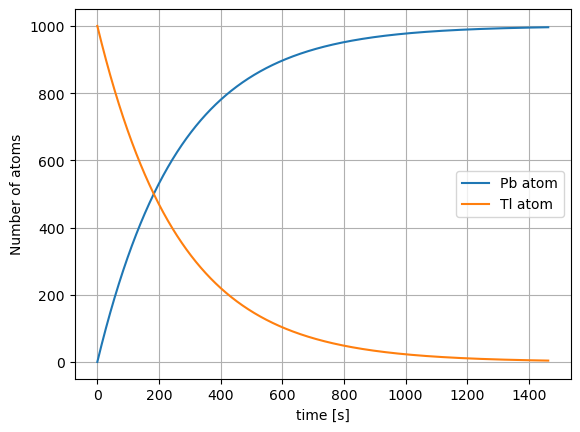

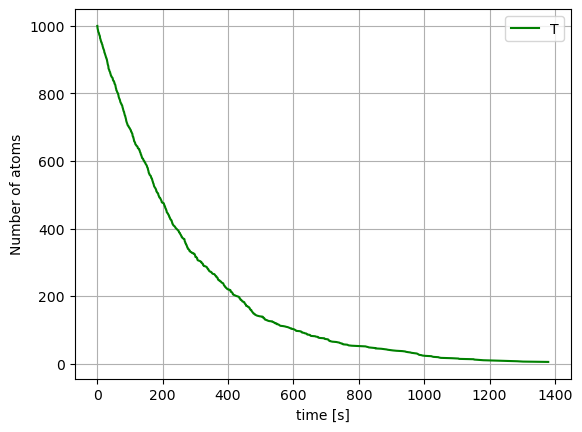

In [2]:
tau = 3.052 * 60
print('tau=',tau)

def p(t,tau):
    return 1-2**(-t/tau)

N=int(8.0*tau)
tl = 1000 * np.ones(N)
lead = 1000 * np.array([p(i,tau) for i in range(N)])
tl = tl - lead
time_axis = range(N)

plt.figure()
plt.plot(time_axis, lead)
plt.plot(time_axis, tl)
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('Number of atoms')
plt.legend(['Pb atom', 'Tl atom'])
plt.show()

def inverse(t):
    return -tau * math.log(1 - t) / math.log(2)


samples=1000
u = np.random.random(samples)
times=np.array([inverse(uvalue) for uvalue in u])
tl = 1000 * np.ones(samples)
times_sorted=np.sort(times)

lead_sample=np.array(range(samples))
plot_times=times_sorted[times_sorted <= N]
Ntoplot=plot_times.shape[0]
plt.plot(times_sorted[0:Ntoplot], tl[0:Ntoplot] - lead_sample[0:Ntoplot], c='green')
plt.xlabel('time [s]')
plt.ylabel('Number of atoms')
plt.legend('Tl atom')
plt.grid()
plt.show()

2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

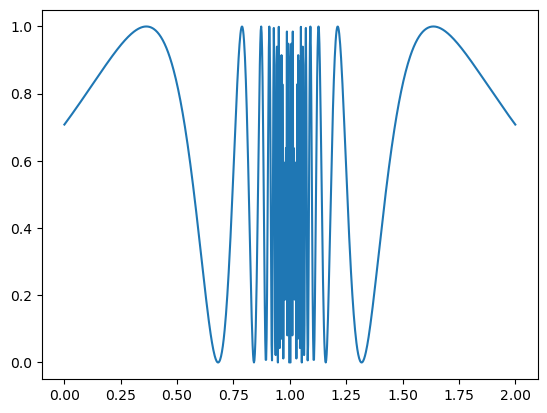

Hit-miss estimate: 1.404
Hit-miss error: 0.0009793132287475742
Mean_value method estimation: 1.285276740851438
Mean_value method error: 0.0652628300143855


In [3]:
def function(x):
    return (np.sin(1/(1-x)))**2
x = np.linspace(0,2,1000)
plt.plot(x,function(x))
plt.show()

N = 1000
hit=0
miss=0

for i in range(N):
    rand_x = np.random.uniform()
    rand_y = np.random.uniform()
    if rand_y <= function(rand_x):
        hit +=1
    else:
        miss+=1

print(f'Hit-miss estimate: {2*hit/N}')

Nn= 100
hit=0
ests = np.zeros(Nn)

for j in range(Nn):
    hit = 0
    for i in range(N):
        rand_x = np.random.uniform()
        rand_y = np.random.uniform()
        if rand_y <= function(rand_x):
            hit +=1
        else:
            miss+=1
    ests[j]=2*hit/N

mean = np.mean(ests)
var = np.var(ests)
err= np.sqrt(var/N)
print(f'Hit-miss error: {err}')

def mean_value_method(N):
    x = np.random.uniform(0,2,N)
    start = function(x)
    est = 2*np.mean(start)
    err = 2*np.std(start)/np.sqrt(N)
    return est,err

es,er = mean_value_method(Nn)
print('Mean_value method estimation:',es)
print('Mean_value method error:',er)


3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [4]:
count=0
N = 10000
for i in range(N):
    x = random()
    y = random()
    if x**2 + y**2 <=1:
        count+=1
print('real value:',np.pi)
print('estimated value, area of 2D',4*count/N)

def f10D(x):
    if (sum(i**2 for i in x))<=1:
        return 1 
    return 0
count=0
x = np.zeros(10)
for i in range(N):
    for j in range(len(x)):
        x[j]=random()
    count += f10D(x)

print('Area of 10D:',count/N*(2**10))

real value: 3.141592653589793
estimated value, area of 2D 3.1344
Area of 10D: 2.3552


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [5]:
def f(x):
    return (x**(-1/2)) / (np.exp(x) + 1)
def w(x):
    return 1 / np.sqrt(x)

N = 100000
int_w= quad(w,0,1)
rng = np.random.default_rng()
x = rng.power(0.5,N)

integral = (int_w[0]/N)*(np.sum(f(x)/w(x)))
print('Integral:',integral)

Integral: 0.8391005649105683
